## Bibliotecas

In [ ]:
import torch    
import os
import random
import numpy                as np
import pandas               as pd
import torch.nn.functional  as F
import matplotlib.pyplot    as plt
import seaborn              as sns
import plotly.graph_objects as go
import plotly.express       as px

import tensorflow as tf
from torch.utils.data import Dataset
from torchvision import transforms

from PIL                         import Image
from torch                       import nn, optim
from torch.nn.modules            import padding
from torch.nn.modules.activation import ReLU

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from torchvision                 import datasets
from plotly.subplots             import make_subplots
from google.colab                import drive

print("Versão:",torch.__version__)

Versão: 2.0.1+cu118


## Leitura de dados

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/gdrive/MyDrive/kaggle_api/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d shiekhburhan/face-mask-dataset

100% 2.33G/2.33G [01:50<00:00, 23.0MB/s]
100% 2.33G/2.33G [01:50<00:00, 22.7MB/s]


In [ ]:
! unzip face-mask-dataset.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: FMD_DATASET/with_mask/simple/simple771.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple772.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple773.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple774.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple775.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple776.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple777.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple778.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple779.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple78.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple780.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple781.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple782.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple783.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple784.jpg  
  inflating: FMD_DATASET/with_mask/simple/simple785.jpg  
  inflating: F

## Tratamento de dados

In [ ]:
data_dir = '/content/FMD_DATASET/'

In [ ]:
# lista todos os diretórios dentro da pasta principal
subfolders = [os.path.join(data_dir, name) for name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, name))]

In [ ]:
subfolders

['/content/FMD_DATASET/without_mask',
 '/content/FMD_DATASET/with_mask',
 '/content/FMD_DATASET/incorrect_mask']

In [ ]:
def adicionar_prefixo_subpastas(caminho_raiz):
    # Percorrer as pastas de rótulo
    for root, dirs, files in os.walk(caminho_raiz):
        for diretorio in dirs:
            # Obter o caminho completo do diretório de rótulo
            caminho_rotulo = os.path.join(root, diretorio)
            
            # Obter o nome do rótulo
            rotulo = os.path.basename(caminho_rotulo)
            
            # Percorrer as subpastas dentro do diretório de rótulo
            for subdiretorio in os.listdir(caminho_rotulo):
                # Obter o caminho completo da subpasta
                caminho_subpasta = os.path.join(caminho_rotulo, subdiretorio)
                
                # Verificar se é um diretório
                if os.path.isdir(caminho_subpasta):
                    # Adicionar o prefixo do rótulo ao nome da subpasta
                    novo_nome = rotulo + '_' + subdiretorio
                    
                    # Renomear a subpasta
                    novo_caminho = os.path.join(caminho_rotulo, novo_nome)
                    os.rename(caminho_subpasta, novo_caminho)
                    print(f"Renomeado: {caminho_subpasta} -> {novo_caminho}")

# Exemplo de uso
caminho_pasta = data_dir  # Substitua pelo seu caminho de pasta

adicionar_prefixo_subpastas(caminho_pasta)

Renomeado: /content/FMD_DATASET/without_mask/complex -> /content/FMD_DATASET/without_mask/without_mask_complex
Renomeado: /content/FMD_DATASET/without_mask/simple -> /content/FMD_DATASET/without_mask/without_mask_simple
Renomeado: /content/FMD_DATASET/with_mask/complex -> /content/FMD_DATASET/with_mask/with_mask_complex
Renomeado: /content/FMD_DATASET/with_mask/simple -> /content/FMD_DATASET/with_mask/with_mask_simple
Renomeado: /content/FMD_DATASET/incorrect_mask/mc -> /content/FMD_DATASET/incorrect_mask/incorrect_mask_mc
Renomeado: /content/FMD_DATASET/incorrect_mask/mmc -> /content/FMD_DATASET/incorrect_mask/incorrect_mask_mmc


In [ ]:
categorias = subfolders[0].split('/')[-1], subfolders[1].split('/')[-1], subfolders[2].split('/')[-1]
categorias = list(categorias)
categorias

['without_mask', 'with_mask', 'incorrect_mask']

In [ ]:
class ImageFolderDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform

        self.class_to_idx = {}
        self.imgs, self.labels = [], []
        idx = 0
        for label in os.listdir(directory):
            if label not in self.class_to_idx:
                self.class_to_idx[label] = idx
                idx += 1
            for filename in os.listdir(os.path.join(directory, label)):
                file_path = os.path.join(directory, label, filename)
                if os.path.isfile(file_path):
                    self.imgs.append(file_path)
                    self.labels.append(self.class_to_idx[label])

    def __getitem__(self, index):
        img_path = self.imgs[index]
        label = self.labels[index] + 1

        img = Image.open(img_path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.imgs)

In [ ]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
train_data = []
test_data = []
train_size = 0.8

# itera sobre cada subpasta
for folder in subfolders:
    dataset = ImageFolderDataset(folder, transform=transforms)
    
    # divide o conjunto de dados em treino e teste
    n = len(dataset)
    n_train = int(train_size * n)
    n_test = n - n_train
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_test])
    
    train_data.append(train_dataset)
    test_data.append(test_dataset)

In [ ]:
# concatena os conjuntos de dados de treino e teste de cada subpasta
train_data = torch.utils.data.ConcatDataset(train_data)

In [ ]:
test_data = torch.utils.data.ConcatDataset(test_data)

In [ ]:
# cria os dataloaders
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
print(len(train_dataloader)*32, len(test_dataloader)*32)

11648 2912


## Model 

In [ ]:
class classificador(nn.Module):
    def __init__(self):
        super(classificador, self).__init__()
        
        #Camadas convolucionais
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Define as camadas densas
        self.dense_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(43264, 128),
            nn.ReLU(),
            nn.Linear(128, 6400),
            nn.ReLU(),
            nn.Linear(6400, 3)
            )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.dense_layers(x)
        return x

In [ ]:
model = classificador()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device,"\n")

model.to(device)

cuda 



classificador(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=43264, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=6400, bias=True)
    (4): ReLU()
    (5): Linear(in_features=6400, out_features=3, bias=True)
  )
)

## Fit

In [ ]:
def train(model, dataLoader, criterion, optimizer):
    model.train()
    cumloss = 0.0
    for imagens, rotulos in dataLoader:
        imagens = imagens.to(device)
        rotulos = rotulos.to(device)

        pred = model(imagens)
        loss = criterion(pred, rotulos)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cumloss += loss.item()

    return cumloss / len(dataLoader)


def validacao(model, dataLoader, lossfunc):
    model.eval()
    cumloss = 0.0
    
    with torch.no_grad():
        for imgs, labels in dataLoader:
            
            imgs, labels = imgs.to(device), labels.to(device)
            
            pred = model(imgs)
            
            loss = lossfunc(pred, labels)
            
            cumloss += loss.item()
            
    return cumloss / len(dataLoader)

epochs = 40
losses_treino = []
losses_teste = []

for i in range(epochs):
  loss_treino = train(model, train_dataloader, criterion, optimizer)
  losses_treino.append(loss_treino)
  if (i%2==0):
    print(f"Época: {i}; Loss Treino: {loss_treino}")

  loss_val = validacao(model, test_dataloader, criterion)
  losses_teste.append(loss_val)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Época: 0; Loss Treino: 0.24653750378254718
Época: 2; Loss Treino: 0.09774874319619202
Época: 4; Loss Treino: 0.06030496363342576
Época: 6; Loss Treino: 0.02985279281901867
Época: 8; Loss Treino: 0.02699494745872101
Época: 10; Loss Treino: 0.0148113896589547
Época: 12; Loss Treino: 0.015151799608693532
Época: 14; Loss Treino: 0.017094171354440878
Época: 16; Loss Treino: 0.006671969707244923
Época: 18; Loss Treino: 0.015422790878111521
Época: 20; Loss Treino: 0.013247886496937037
Época: 22; Loss Treino: 0.011256905933570174
Época: 24; Loss Treino: 0.004252263086014706
Época: 26; Loss Treino: 0.006545009966742512
Época: 28; Loss Treino: 0.014711803667301406
Época: 30; Loss Treino: 0.005738730301118091
Época: 32; Loss Treino: 0.005001776066896659
Época: 34; Loss Treino: 0.012864264130480675
Época: 36; Loss Treino: 0.0032260908698402433
Época: 38; Loss Treino: 0.005087430598409371


## Metricas

In [ ]:
def plot_loss(losses):
  fig = plt.figure(figsize=(13,5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Epoch", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs epochs", fontsize="16");

def make_confusion_matrix(model, loader, classes):
  confusion_matrix = torch.zeros(classes, classes, dtype=torch.int64)
  with torch.no_grad():
    for i ,(imagens, rotulos) in enumerate(loader):
      imagens, rotulos = imagens.to(device), rotulos.to(device) 
      output = model(imagens)
      _, pred = torch.max(output, 1)
      for j, k in zip(torch.as_tensor(rotulos, dtype=torch.int64).view(-1),
                      torch.as_tensor(pred, dtype=torch.int64).view(-1)):
        confusion_matrix[j, k] += 1
  return confusion_matrix 


def evaluate_accuracy(model, loader, classes, verbose=True):

  pred_corretos = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  confusion_matrix = make_confusion_matrix(model, loader, len(classes))

  if (verbose):
    total_de_correto = 0.0
    total_de_preditos = 0.0

    for i, classname in enumerate(classes):
      correct_count = confusion_matrix[i][i].item()
      class_pred = torch.sum(confusion_matrix[i]).item()

      total_de_correto += correct_count
      total_de_preditos += class_pred

      accuracy = 100 * float(correct_count) / class_pred
      print("Acurácia da classe {}: {:.2f}".format(classname,
                                                    accuracy))
  print("Acurácia geral: {:.2f}".format(100 * total_de_correto/total_de_preditos))
  return confusion_matrix

def test(model, loader, classes):
  pred_corretos = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}
  with torch.no_grad():
    for imagens, rotulos in loader:
      imagens, rotulos = imagens.to(device), rotulos.to(device) 
      output = model(imagens)
      _, pred = torch.max(output, 1)
      for rotulo, previsoes in zip(rotulos, pred):
        if rotulo == previsoes:
          pred_corretos[classes[rotulo]] += 1
        total_pred[classes[rotulo]] += 1


  total_de_correto = 0.0
  total_de_preditos = 0.0
  for nome_da_classe, qtd_corretos in pred_corretos.items():
    total_de_correto += qtd_corretos
    total_de_preditos += total_pred[nome_da_classe]
    acuracia = 100* float(qtd_corretos) / total_pred[nome_da_classe]
    print("Acurácia da classe {}: {:.2f}".format(nome_da_classe, acuracia))
  print("Acurácia geral: {:.2f}".format(100*total_de_correto/total_de_preditos))

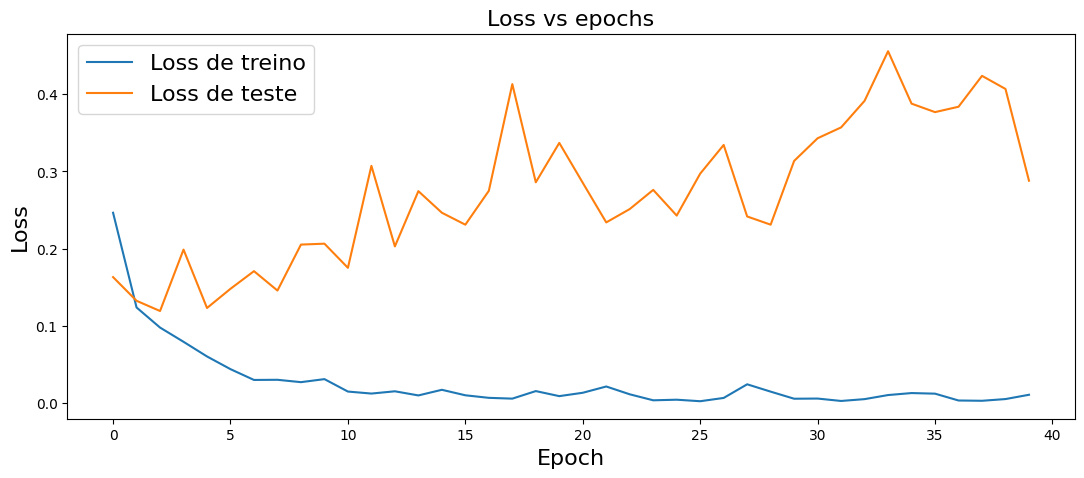

In [ ]:
grafico_de_loss = {'Loss de treino':losses_treino,
                  'Loss de teste':losses_teste}
plot_loss(grafico_de_loss)

In [ ]:
matriz = evaluate_accuracy(model, test_dataloader, categorias)

plt.figure(figsize=(8, 7))
sns.set(font_scale=1.4)
sns.heatmap(matriz.tolist(), 
           annot=True, annot_kws={"size": 16}, fmt='d', cmap='viridis')

ZeroDivisionError: ignored